In [130]:
## Source: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM, Activation, Dropout
from keras.optimizers import RMSprop
from gensim.models import Word2Vec

import pandas as pd
import numpy as np
import datetime

MAX_NB_WORDS = 22500
MAX_SEQUENCE_LENGTH = 1108
VALIDATION_SPLIT = 0.25



## Import the data

In [110]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

texts = list(df['content'])
df_labels = list(df['relevant'])

(1984, 13)


## Format into tensors

In [111]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')
print(f'Maximum text length: {max([len(x) for x in sequences])}')

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(df_labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]



Found 22151 unique tokens
Maximum text length: 1108
Shape of data tensor: (1984, 1108)
Shape of label tensor: (1984, 2)


In [135]:
w2v = Word2Vec.load("w2v/sus_w2v.model")
print(len(w2v.wv.vocab))

684020


In [136]:
embedding_matrix = np.zeros((len(word_index) + 1, w2v.vector_size))
for word, i in word_index.items():
    try:
        embedding_vector = w2v.wv[word]
        embedding_matrix[i] = embedding_vector
    except:
        # word not in embedding index
        print(f'{word} not in index')



embedding_layer = Embedding(
    len(word_index) + 1,
    w2v.vector_size,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

scco not in index
cydv not in index
like1 not in index
mtco not in index
kgco not in index
ghao not in index
glp not in index
k3 not in index
004 not in index
aimcm not in index
otipm not in index
ferro not in index
imilp not in index
iagre not in index
0749 not in index
0208 not in index
bche not in index
hincii not in index
butanone not in index
enda not in index
hks not in index
hydroxybutyric not in index
mart not in index
ni2 not in index
0001 not in index
rhinotermitidae not in index
rd3 not in index
mi1 not in index
mi7 not in index
gvi not in index
ramy not in index
cbds not in index
furandicarboxylic not in index
nitrocatechol not in index
046 not in index
enoic not in index
so42 not in index
mmy not in index
kra not in index
smax not in index
25cr not in index
60sa not in index
ciccs not in index
1061 not in index
dendroica not in index
throated not in index
gmelin not in index
sulfonatobenzyl not in index
worker' not in index
dibromoethane not in index
navier not in index
pn

## Convolutional Neural Net

In [118]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

Train on 1488 samples, validate on 496 samples
Epoch 1/10
1488/1488 [==============================] - 15s 10ms/step - loss: 1.0024 - acc: 0.7164 - val_loss: 0.5690 - val_acc: 0.7480
Epoch 2/10
1488/1488 [==============================] - 16s 11ms/step - loss: 0.5196 - acc: 0.7641 - val_loss: 0.5485 - val_acc: 0.7480
Epoch 3/10
1488/1488 [==============================] - 17s 12ms/step - loss: 0.4715 - acc: 0.7601 - val_loss: 0.6827 - val_acc: 0.7480
Epoch 4/10
1488/1488 [==============================] - 81s 55ms/step - loss: 0.4336 - acc: 0.8313 - val_loss: 0.5685 - val_acc: 0.7359
Epoch 5/10
1488/1488 [==============================] - 26s 18ms/step - loss: 0.3781 - acc: 0.8535 - val_loss: 0.6200 - val_acc: 0.6633
Epoch 6/10
1488/1488 [==============================] - 21s 14ms/step - loss: 0.3405 - acc: 0.8468 - val_loss: 0.9268 - val_acc: 0.7480
Epoch 7/10
1488/1488 [==============================] - 19s 13ms/step - loss: 0.3089 - acc: 0.8810 - val_loss: 0.4212 - val_acc: 0.8367
E

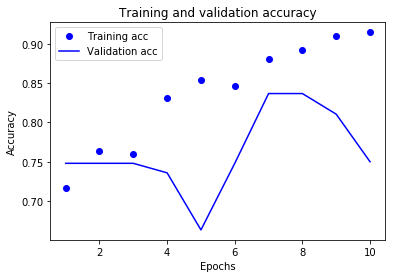

In [121]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [132]:
def RNN():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    layer = LSTM(64)(embedded_sequences)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=sequence_input,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 1108)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1108, 300)         6645600   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 2)                 514       
__________